In [1]:
# Data representation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as pxp
import plotly.graph_objs as gph
from yellowbrick.cluster import SilhouetteVisualizer
import graphviz

# Machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import scipy.cluster.hierarchy as ch
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import  KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering, DBSCAN
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Train and Testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, silhouette_score, davies_bouldin_score

# Save and get model(s)
import pickle

## Introduction

In this project, we will apply different stastistical methods, to try and analyse patterns and correlation in different lifestyle factors. This will involve trying to train different machine learning models, to see how precisely these patterns can be used to predict how much carbon is emitted based on the correlating factors.
We will try to answer the following questions: 

- Which are the most decisive factors for carbon emissions for an individual?
- Does internet usage directly affect total carbon emissions?
- Does the important factors differ between males and females?
- Does people who see themselves as "energy efficient" generally have lower total carbon emissions?
- Are the people travelling frequently by plane, the ones who are emitting the most carbon?
- Which machine learning methods did you choose to apply in the application?
- How accurate is your solution of prediction?
- Which were the challenges in the project development?

# Data Preparation

### Data Collection / loading:

In [2]:
# Reading the data from csv into pandas dataframe:
df = pd.read_csv('./data/Carbon-Emission.csv', index_col=None, na_values=['NA'])

In [3]:
# Viewing the size of the dataframe:
df.shape

(10000, 20)

In [4]:
df.sample(5)


,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
4007,overweight,male,omnivore,daily,coal,walk/bicycle,NaN,often,272,never,60,medium,5,17,24,10,No,['Glass'],"['Oven', 'Microwave']",2246
3788,obese,female,omnivore,twice a day,wood,public,NaN,sometimes,266,very frequently,1020,small,7,21,12,6,Sometimes,['Metal'],"['Grill', 'Airfryer']",2898
503,overweight,male,vegan,daily,electricity,walk/bicycle,NaN,sometimes,144,frequently,50,large,2,20,47,5,Yes,['Glass'],"['Stove', 'Oven']",2176
4471,normal,female,vegan,less frequently,electricity,public,NaN,never,59,very frequently,1902,extra large,5,24,33,10,Sometimes,"['Paper', 'Metal']","['Stove', 'Grill', 'Airfryer']",2352
2336,obese,female,omnivore,less frequently,electricity,public,NaN,never,133,never,670,medium,5,17,12,7,Sometimes,"['Paper', 'Plastic', 'Glass']",[],833


In [5]:
df.iloc[[7511]]

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
7511,obese,male,omnivore,daily,electricity,public,NaN,often,195,rarely,606,medium,2,7,15,24,Sometimes,"['Paper', 'Glass']","['Oven', 'Grill', 'Airfryer']",1574


In [6]:
list(df)

['Body Type',
 'Sex',
 'Diet',
 'How Often Shower',
 'Heating Energy Source',
 'Transport',
 'Vehicle Type',
 'Social Activity',
 'Monthly Grocery Bill',
 'Frequency of Traveling by Air',
 'Vehicle Monthly Distance Km',
 'Waste Bag Size',
 'Waste Bag Weekly Count',
 'How Long TV PC Daily Hour',
 'How Many New Clothes Monthly',
 'How Long Internet Daily Hour',
 'Energy efficiency',
 'Recycling',
 'Cooking_With',
 'CarbonEmission']

In [7]:
#
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Body Type                      10000 non-null  object
 1   Sex                            10000 non-null  object
 2   Diet                           10000 non-null  object
 3   How Often Shower               10000 non-null  object
 4   Heating Energy Source          10000 non-null  object
 5   Transport                      10000 non-null  object
 6   Vehicle Type                   3279 non-null   object
 7   Social Activity                10000 non-null  object
 8   Monthly Grocery Bill           10000 non-null  int64 
 9   Frequency of Traveling by Air  10000 non-null  object
 10  Vehicle Monthly Distance Km    10000 non-null  int64 
 11  Waste Bag Size                 10000 non-null  object
 12  Waste Bag Weekly Count         10000 non-null  int64 
 13  Ho

In [8]:
# Replacing nan values with None, this we do beacuse we know/can see that pepole that dont drive has nan values as vehicle type
df = df.replace(np.nan, 'None')

In [9]:
df.isnull().sum()

Body Type                        0
Sex                              0
Diet                             0
How Often Shower                 0
Heating Energy Source            0
Transport                        0
Vehicle Type                     0
Social Activity                  0
Monthly Grocery Bill             0
Frequency of Traveling by Air    0
Vehicle Monthly Distance Km      0
Waste Bag Size                   0
Waste Bag Weekly Count           0
How Long TV PC Daily Hour        0
How Many New Clothes Monthly     0
How Long Internet Daily Hour     0
Energy efficiency                0
Recycling                        0
Cooking_With                     0
CarbonEmission                   0
dtype: int64

In [10]:
# Getting some insights of the value scope:
df.describe()

,Monthly Grocery Bill,Vehicle Monthly Distance Km,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,CarbonEmission
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,173.875200,2031.485900,4.024600,12.139200,25.109000,11.889100,2269.147300
std,72.234018,2769.715597,1.990375,7.106369,14.698725,7.277218,1017.675247
min,50.000000,0.000000,1.000000,0.000000,0.000000,0.000000,306.000000
25%,111.000000,69.000000,2.000000,6.000000,13.000000,6.000000,1538.000000
50%,173.000000,823.000000,4.000000,12.000000,25.000000,12.000000,2080.000000
75%,237.000000,2516.750000,6.000000,18.000000,38.000000,18.000000,2768.000000
max,299.000000,9999.000000,7.000000,24.000000,50.000000,24.000000,8377.000000


In [11]:
# Chek numeric values for distribution
num_cols = df.select_dtypes(include=['int64']).columns
df_nums = df[num_cols]
df_nums.dtypes

Monthly Grocery Bill            int64
Vehicle Monthly Distance Km     int64
Waste Bag Weekly Count          int64
How Long TV PC Daily Hour       int64
How Many New Clothes Monthly    int64
How Long Internet Daily Hour    int64
CarbonEmission                  int64
dtype: object

array([[<Axes: title={'center': 'Monthly Grocery Bill'}>,
        <Axes: title={'center': 'Vehicle Monthly Distance Km'}>,
        <Axes: title={'center': 'Waste Bag Weekly Count'}>],
       [<Axes: title={'center': 'How Long TV PC Daily Hour'}>,
        <Axes: title={'center': 'How Many New Clothes Monthly'}>,
        <Axes: title={'center': 'How Long Internet Daily Hour'}>],
       [<Axes: title={'center': 'CarbonEmission'}>, <Axes: >, <Axes: >]],
      dtype=object)

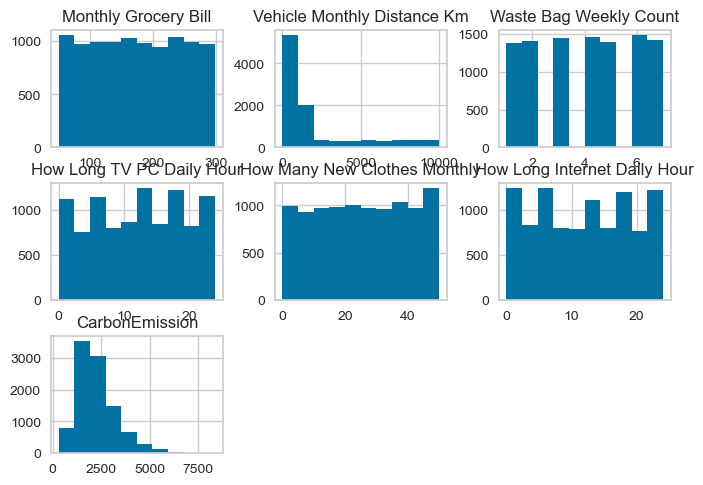

In [12]:
df_nums.hist()

<Axes: >

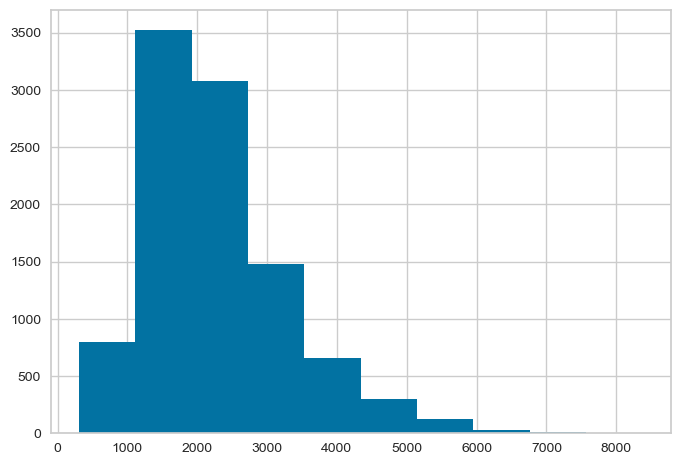

In [13]:
df_nums['CarbonEmission'].hist()

### Data cleaning and exploration

It looks like it follows a kind of skewed normal distribution, with a few outliers lying greatly above the mean

In [14]:
# Encode/transform data numeric
label_encoder = LabelEncoder()

# Making copy of df to a new dataframe called: df_numeric 
df_numeric = df

# Gettning all columns that has object type:
cate_columns = df.select_dtypes(include=['object']).columns

for column in cate_columns:
    df_numeric[column] = label_encoder.fit_transform(df[column])

In [15]:
# Verifying that cols have been encoded:
df_numeric.sample(5)

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
9952,2,0,0,1,2,1,0,2,271,0,615,0,7,9,28,21,1,3,2,2498
9967,1,1,0,0,2,2,0,0,282,2,62,3,3,8,37,1,1,8,4,1757
6020,2,1,1,2,2,1,0,2,165,2,190,0,3,5,35,15,2,15,5,2157
3376,3,1,3,3,3,2,0,2,142,0,27,3,4,14,50,11,2,0,1,2096
7311,2,1,1,2,1,2,0,2,264,2,64,3,3,13,41,5,1,9,9,1534


In [16]:
corr_matrix = df_numeric.corr()

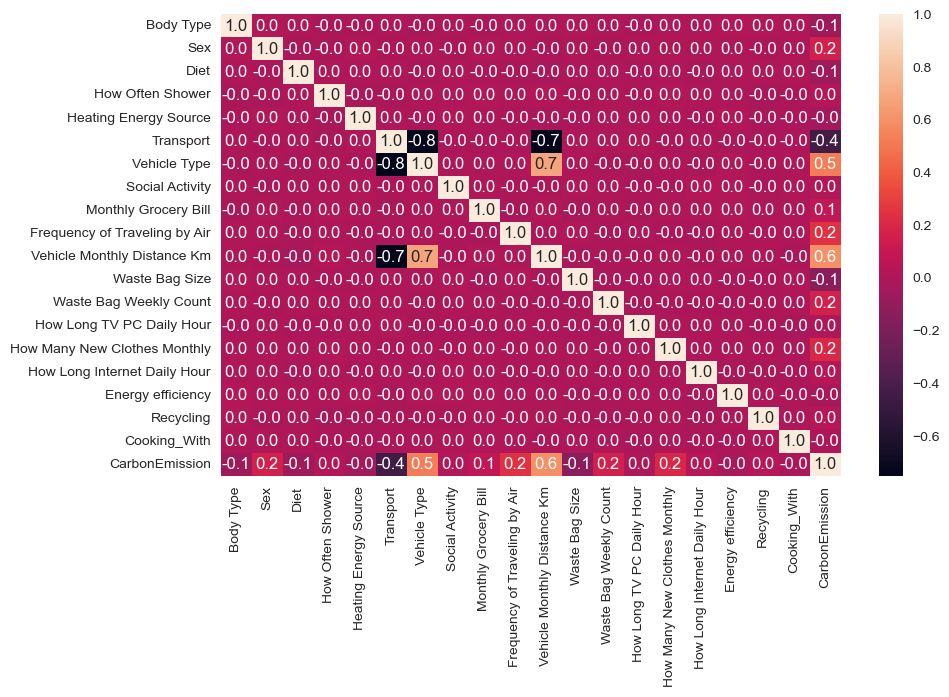

In [17]:
# Heatmap that can show correlation
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, fmt=".1f")
plt.show()

The biggest correlation with carbon emissions, seem to be the monthly travelled distance by personal vehicle. Other factor with clear correlations seem to be type of transport, vehicle type and frequency of travelling with airplane. There also seem to be a smaller correlation with the amount of clothes people buy.

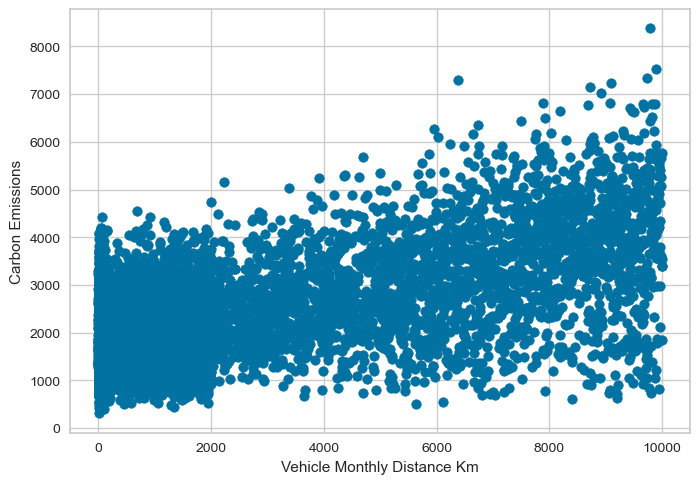

In [18]:
plt.xlabel('Vehicle Monthly Distance Km')
plt.ylabel('Carbon Emissions')
plt.scatter(df_numeric['Vehicle Monthly Distance Km'], df_numeric['CarbonEmission'])
plt.show()

Does internet usage have an impact on carbon emissions?

In [19]:
corr_matrix['CarbonEmission']['How Long Internet Daily Hour']

0.043878026391883734

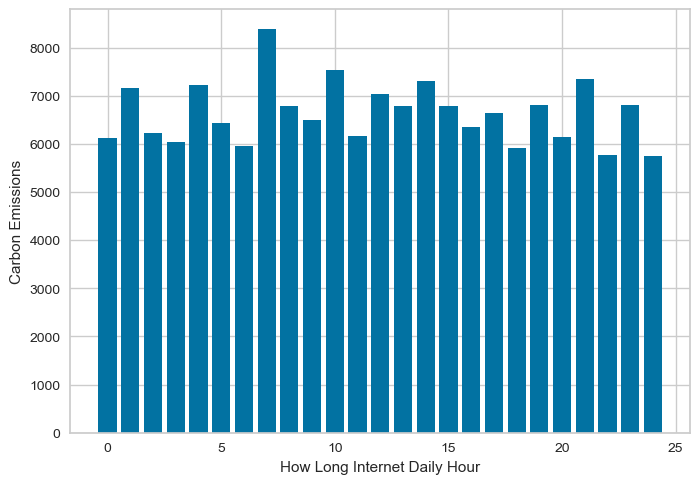

In [20]:
plt.xlabel('How Long Internet Daily Hour')
plt.ylabel('Carbon Emissions')
plt.bar(df_numeric['How Long Internet Daily Hour'], df_numeric['CarbonEmission'])
plt.show()

There is a slight correlation, but nowhere near enough to asser any tendencies. We are lucky computer people!

Let's see if theres as difference between male an female patterns

In [21]:
# Split dataframe based on sex, and see if theres a difference in the correlation
df_male = df_numeric[df_numeric['Sex'] == 1]
df_male

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
2,2,1,0,2,3,0,5,0,138,1,2472,3,1,14,47,6,1,2,5,2595
3,2,1,0,3,3,2,0,2,157,2,74,2,3,20,5,7,1,6,1,1074
5,2,1,3,1,3,1,0,2,144,0,658,1,1,22,18,9,1,3,12,1647
8,2,1,0,0,3,1,0,0,200,0,1376,2,3,3,31,15,2,1,1,2494
11,1,1,3,2,0,2,0,0,111,3,69,2,5,9,4,4,1,15,12,3226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,1,1,0,2,0,1,0,0,120,2,421,1,3,10,33,6,2,9,7,2077
9993,3,1,1,2,3,2,0,2,118,0,78,2,3,8,14,10,1,15,6,1794
9995,1,1,0,3,0,0,3,2,230,1,268,2,5,12,27,9,2,15,2,2408
9998,3,1,2,2,0,0,5,1,179,2,8688,2,5,19,14,5,1,5,8,4574


In [22]:
df_female = df_numeric[df_numeric['Sex'] == 0]
df_female

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
0,2,0,1,0,0,1,0,1,230,0,210,1,4,7,26,1,0,2,13,2238
1,1,0,3,1,2,2,0,1,114,2,9,0,3,9,38,5,0,2,9,1892
4,1,0,3,0,0,0,1,1,266,3,8457,1,1,3,5,6,2,10,6,4743
6,3,0,2,1,3,0,3,0,56,2,5363,2,4,9,11,19,1,15,0,1832
7,3,0,2,2,0,2,0,2,59,3,54,0,3,5,39,15,0,7,9,2322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,3,0,0,2,1,1,0,2,226,0,755,2,7,16,17,4,2,8,9,1412
9991,1,0,0,2,0,2,0,0,55,2,82,2,2,19,10,11,1,0,2,1278
9994,0,0,3,2,3,0,5,0,89,2,4482,1,5,15,17,22,1,15,5,2999
9996,0,0,2,3,0,0,4,0,234,0,5316,0,3,14,8,24,1,9,9,3084


In [23]:
df_male_corr = df_male.corr()
df_female_corr = df_female.corr()

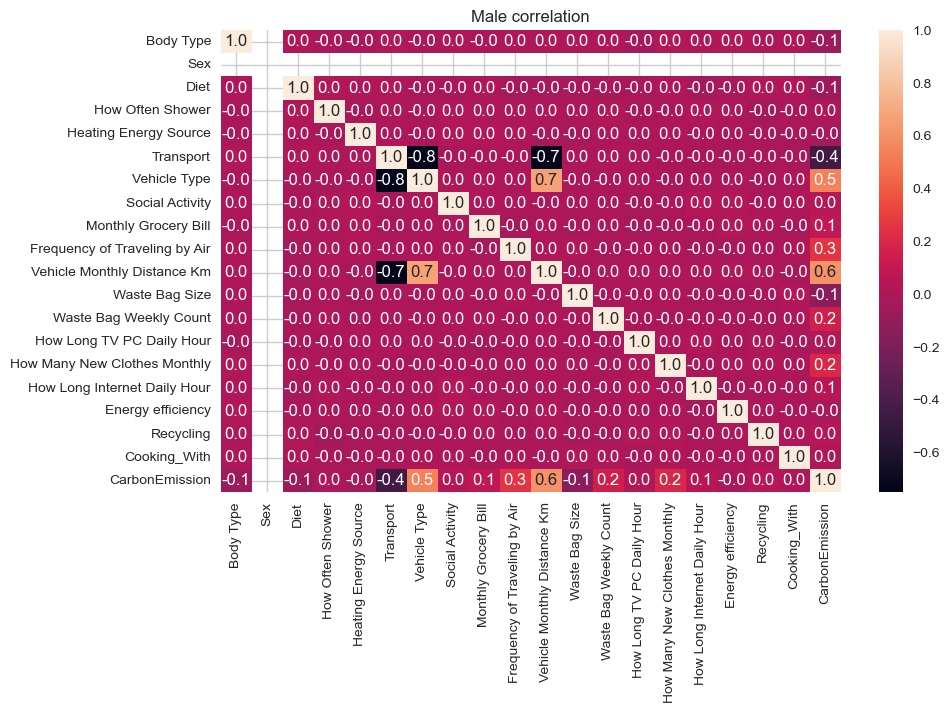

In [24]:
plt.figure(figsize=(10,6))
sns.heatmap(df_male_corr, annot=True, fmt=".1f")
plt.title('Male correlation')
plt.show()

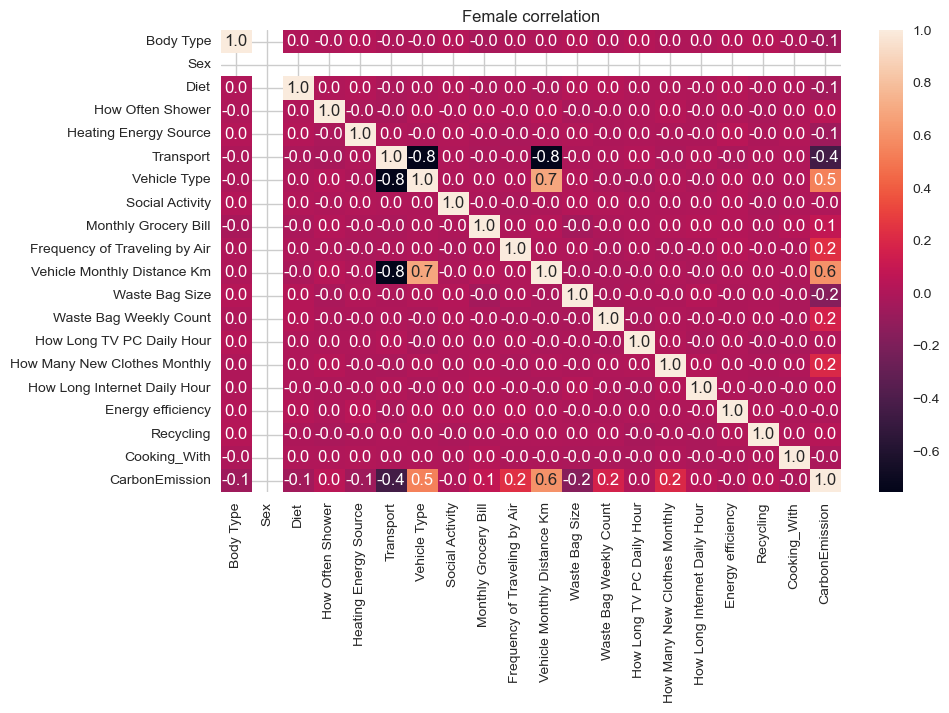

In [25]:
plt.figure(figsize=(10,6))
sns.heatmap(df_female_corr, annot=True, fmt=".1f")
plt.title('Female correlation')
plt.show()

There doesn't really seem to be a difference of how much the factors weigh between males and females

### Outliers

<Axes: >

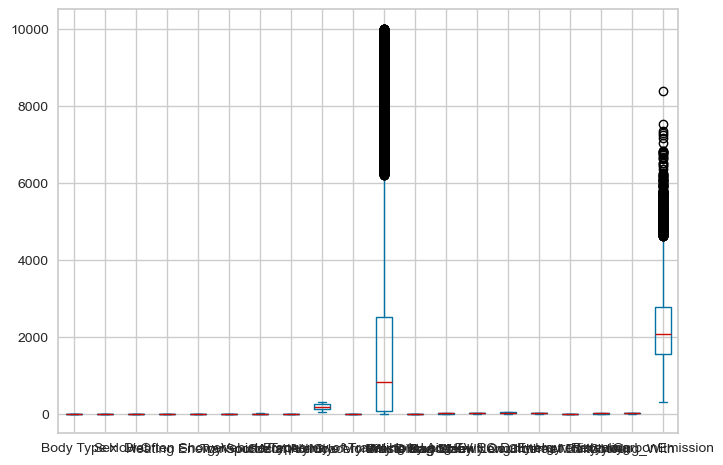

In [26]:
df_numeric.plot.box()

<Axes: >

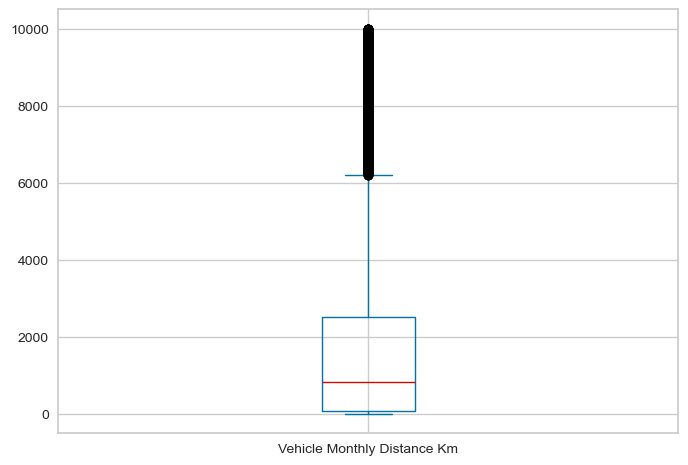

In [27]:
df_nums['Vehicle Monthly Distance Km'].plot.box()

In [28]:
med = df_nums['Vehicle Monthly Distance Km'].median()
df_nums['Vehicle Monthly Distance Km'].max() - med

9176.0

As we can see, the distribution of distance travelled by vehicle is very skewed, with 75% of the data lying beneath 3000 km pr month, with quite a few outlier being outragerously above the median. This might still be an accurate representation though, since some individuals just might travel that much. 
We'll keep it for the variance

Let's see if people are as accurate as they think, when they say they're energy efficient!

In [29]:
test = df_numeric.iloc[[6550]]
test

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
6550,3,1,2,3,3,2,0,2,157,3,13,3,2,20,45,12,2,3,2,2372


In [30]:
grouped_data = df.groupby('Energy efficiency')

grouped = df.groupby('Energy efficiency')['CarbonEmission'].agg(['mean', 'sum']).reset_index()
grouped

,Energy efficiency,mean,sum
0,0,2286.656628,7365321
1,1,2269.151314,7858071
2,2,2252.135404,7468081


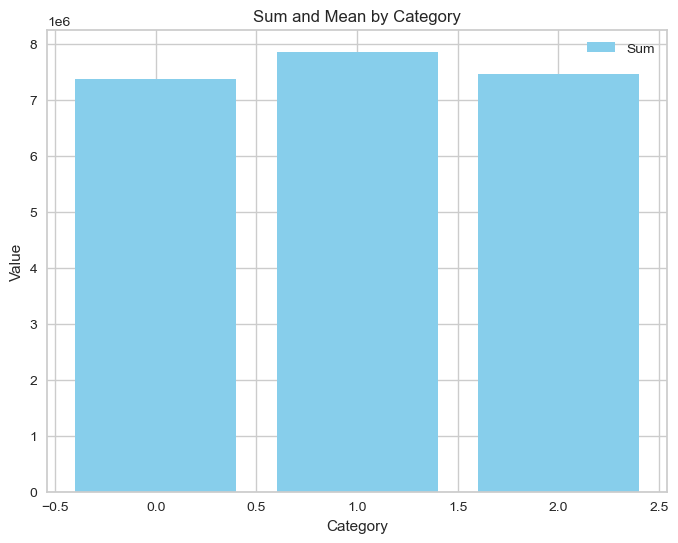

In [31]:
plt.figure(figsize=(8, 6))
plt.bar(grouped['Energy efficiency'], grouped['sum'], color='skyblue', label='Sum')
# plt.bar(grouped['Energy efficiency'], grouped['mean'], color='orange', label='Mean')
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Sum and Mean by Category')
plt.legend()
plt.show()

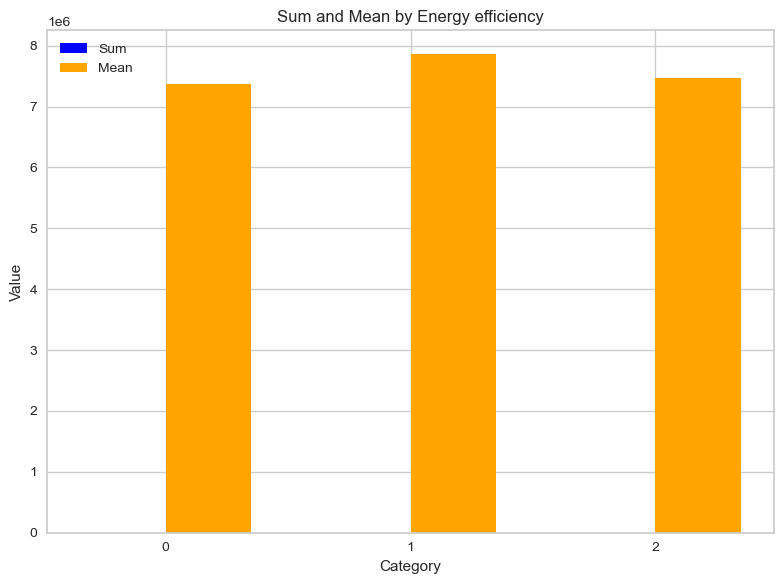

In [32]:
plt.figure(figsize=(8, 6))

# Define the width of each bar
bar_width = 0.35

# Define the positions for the bars
index = np.arange(len(grouped['Energy efficiency']))

# Create side-by-side bars for 'Sum' and 'Mean'
plt.bar(index, grouped['mean'], bar_width, color='blue', label='Sum')
plt.bar(index + bar_width, grouped['sum'], bar_width, color='orange', label='Mean')

# Add labels, title, and legend
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Sum and Mean by Energy efficiency')
plt.xticks(index + bar_width / 2, grouped['Energy efficiency'])
plt.legend()

plt.tight_layout()
plt.show()

<Axes: xlabel='Energy efficiency'>

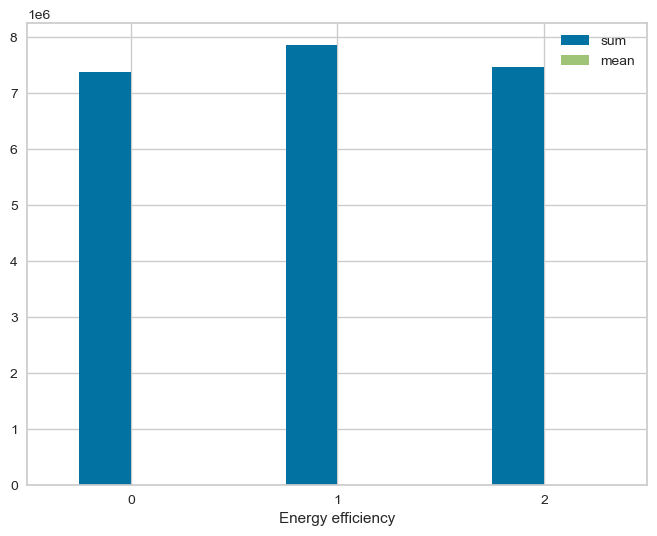

In [33]:
grouped['sum'] = grouped['sum'].astype(float)
grouped['mean'] = grouped['mean'].astype(float)
grouped.plot.bar(x='Energy efficiency', y=['sum','mean'], figsize=(8, 6), rot=0)

We can see that people say that the are energy efficient generally tend to have a little bit lower carbon emission in total, but the difference really is only about 1,5% lower than the 'No' category.

The total sum of carbon emissions seems to be higher by people declaring that they're being energy efficient, indicating that a lot more people think they are being efficient than not, while not really making any difference in the emitted carbon dioxide!

### Plane travel

We can see theres a small correlation between the Frequency of air travel, and their carbon emission, let's sxplore what it means

In [34]:
group_air = df.groupby('Frequency of Traveling by Air').size().reset_index(name='Count')
group_air

,Frequency of Traveling by Air,Count
0,0,2524
1,1,2459
2,2,2477
3,3,2540


<Axes: ylabel='Count'>

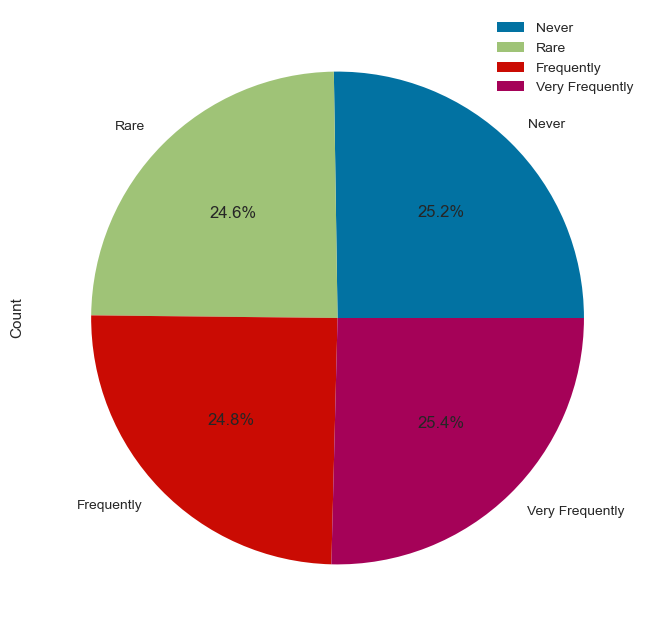

In [35]:
# Plot the distribution of the frequency
group_air.plot.pie(y='Count', labels=['Never', 'Rare', 'Frequently', 'Very Frequently'], autopct='%1.1f%%', figsize=(8, 8))

In [36]:
grouped = df.groupby('Frequency of Traveling by Air')['CarbonEmission'].agg(['mean', 'sum']).reset_index()
grouped

,Frequency of Traveling by Air,mean,sum
0,0,2362.866482,5963875
1,1,1716.337129,4220473
2,2,1945.872830,4819927
3,3,3026.455906,7687198


<Axes: xlabel='Frequency of Traveling by Air'>

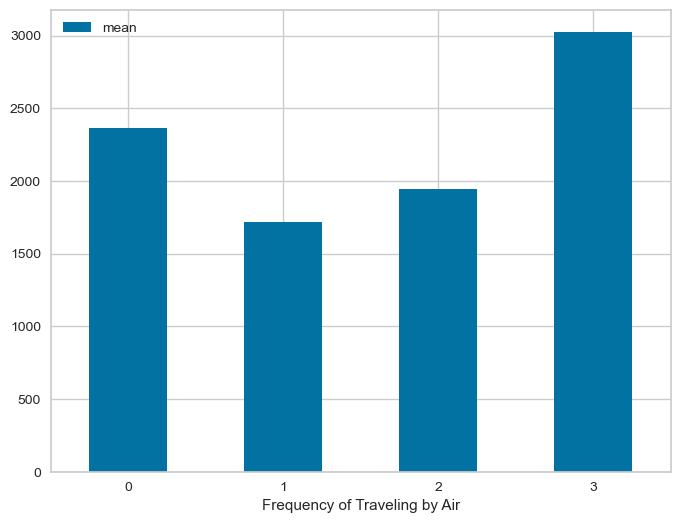

In [37]:
grouped.plot.bar(x='Frequency of Traveling by Air', y=['mean'], figsize=(8, 6), rot=0)

As we can see, the distribution of people is fairly equal between all different categories of flight frequency, but there's a clearly tendency of higher average carbon emissions from people who are in the 'very frequent' category.

The mean carbon emssions are around 22% higher for people who travel very frequently by air.


## Supervised Machine learning

Let's try and see if we can predict total carbon emission values by training different classifier models.
Since we're doing classification, we'll bin the carbon emission numbers into categories

In [38]:
df_numeric.sample(5)

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
2994,0,0,2,1,1,1,0,2,298,2,1664,1,1,4,35,7,2,10,2,1101
7814,2,1,0,1,1,2,0,1,298,2,8,3,4,10,29,15,1,3,15,1439
3628,2,0,1,3,1,0,5,0,51,3,9165,3,5,13,11,18,2,12,2,5111
7967,1,0,3,1,2,1,0,1,235,0,883,3,7,11,48,22,1,2,0,2521
2764,2,1,0,3,3,1,0,2,69,3,1080,2,3,3,35,4,2,15,7,2861


In [39]:
scaled_data = df_numeric[['CarbonEmission']]

In [40]:
qtrans = QuantileTransformer(output_distribution='normal', random_state=0)
scaled_data['CarbonEmission_trans_norm'] = qtrans.fit_transform(scaled_data[['CarbonEmission']])

print('Mean:', scaled_data['CarbonEmission_trans_norm'].mean())
print('Standard Deviation:', scaled_data['CarbonEmission_trans_norm'].std())

Mean: -5.7164614667183854e-05
Standard Deviation: 1.0008721999469523


C:\Users\Oscar\AppData\Local\Temp\ipykernel_7140\3406664864.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_data['CarbonEmission_trans_norm'] = qtrans.fit_transform(scaled_data[['CarbonEmission']])


In [41]:
scaled_data.describe()

,CarbonEmission,CarbonEmission_trans_norm
count,10000.000000,10000.000000
mean,2269.147300,-0.000057
std,1017.675247,1.000872
min,306.000000,-5.199338
25%,1538.000000,-0.673702
50%,2080.000000,0.000000
75%,2768.000000,0.675027
max,8377.000000,5.199338


In [42]:
df_part = df_numeric.copy().drop(columns=['CarbonEmission'], axis=1)
df_bin = pd.concat([df_part, scaled_data['CarbonEmission_trans_norm']], axis=1)
df_bin

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission_trans_norm
0,2,0,1,0,0,1,0,1,230,0,210,1,4,7,26,1,0,2,13,0.165943
1,1,0,3,1,2,2,0,1,114,2,9,0,3,9,38,5,0,2,9,-0.200818
2,2,1,0,2,3,0,5,0,138,1,2472,3,1,14,47,6,1,2,5,0.519512
3,2,1,0,3,3,2,0,2,157,2,74,2,3,20,5,7,1,6,1,-1.497997
4,1,0,3,0,0,0,1,1,266,3,8457,1,1,3,5,6,2,10,6,1.883938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,1,0,3,0,0,3,2,230,1,268,2,5,12,27,9,2,15,2,0.336178
9996,0,0,2,3,0,0,4,0,234,0,5316,0,3,14,8,24,1,9,9,0.925534
9997,2,0,3,0,1,2,0,2,298,3,96,0,5,11,5,24,2,8,1,0.303402
9998,3,1,2,2,0,0,5,1,179,2,8688,2,5,19,14,5,1,5,8,1.794943


In [43]:
emission_max = df_bin['CarbonEmission_trans_norm'].max()
emission_min = df_bin['CarbonEmission_trans_norm'].min()

bins = np.linspace(emission_min -1, emission_max, 4)

df_bin['EmissionBin'] = pd.cut(df_bin['CarbonEmission_trans_norm'], bins=3, labels=False)
df_bin.describe()


,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,...,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission_trans_norm,EmissionBin
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.509400,0.499300,1.491900,1.493700,1.486500,1.014800,0.991300,0.98690,173.875200,1.503300,...,1.502400,4.024600,12.139200,25.109000,11.889100,1.009500,7.542100,7.514400,-0.000057,0.999900
std,1.119213,0.500025,1.113489,1.123604,1.116755,0.818809,1.630549,0.81731,72.234018,1.123795,...,1.120321,1.990375,7.106369,14.698725,7.277218,0.808502,4.629295,4.583611,1.000872,0.288978
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,50.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.199338,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,111.000000,0.000000,...,0.750000,2.000000,6.000000,13.000000,6.000000,0.000000,3.000000,4.000000,-0.673702,1.000000
50%,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000,173.000000,2.000000,...,1.000000,4.000000,12.000000,25.000000,12.000000,1.000000,8.000000,8.000000,0.000000,1.000000
75%,3.000000,1.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.00000,237.000000,3.000000,...,3.000000,6.000000,18.000000,38.000000,18.000000,2.000000,12.000000,12.000000,0.675027,1.000000
max,3.000000,1.000000,3.000000,3.000000,3.000000,2.000000,5.000000,2.00000,299.000000,3.000000,...,3.000000,7.000000,24.000000,50.000000,24.000000,2.000000,15.000000,15.000000,5.199338,2.000000


In [44]:
grouped_bin = df_bin.groupby('EmissionBin').size().reset_index(name='Count')
grouped_bin

,EmissionBin,Count
0,0,418
1,1,9165
2,2,417


In [45]:
df_bin.drop('CarbonEmission_trans_norm', axis=1, inplace=True)
df_bin.sample(5)

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,EmissionBin
5837,3,1,1,3,2,2,0,2,104,2,35,2,7,22,0,20,0,8,3,1
5703,2,0,0,1,0,1,0,1,198,0,826,1,7,15,42,10,1,6,1,1
1367,0,0,2,3,3,1,0,0,54,2,1763,3,4,23,39,11,2,8,7,1
6040,3,1,0,3,2,2,0,0,85,1,86,1,6,20,17,11,1,15,10,1
1342,3,1,2,0,0,2,0,2,204,2,27,3,5,12,7,16,0,15,13,1


### Model training

#### Naive Bayes model

In [46]:
df_bin.head()

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,EmissionBin
0,2,0,1,0,0,1,0,1,230,0,210,1,4,7,26,1,0,2,13,1
1,1,0,3,1,2,2,0,1,114,2,9,0,3,9,38,5,0,2,9,1
2,2,1,0,2,3,0,5,0,138,1,2472,3,1,14,47,6,1,2,5,1
3,2,1,0,3,3,2,0,2,157,2,74,2,3,20,5,7,1,6,1,1
4,1,0,3,0,0,0,1,1,266,3,8457,1,1,3,5,6,2,10,6,2


In [47]:
# Convert the dataset into array
array = df_bin.values
# Create two axis for the test data
X = array[:,0:19] 
Y = array[:,-1]   # CarbonEmission
Y

array([1, 1, 1, ..., 1, 2, 0], dtype=int64)

In [48]:
# split proportion
test_set_size = 0.15

# Initial value for randomization
seed = 42 # this is the answer
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_set_size, random_state=seed)

In [49]:
# Use GaussianNB for numeric data
nb = GaussianNB()
nb.fit(X_train, Y_train)

GaussianNB()

In [50]:
# test the model
nb.score(X_test, Y_test)

0.8633333333333333

An accuracy of about 70 percent, not bad for a first try, but I think we can do better.
Let's try to focus on the correlating values

In [51]:
column_indexes = [0, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14] # Columns with correlation > 0.1
df_features = df_numeric.iloc[:, column_indexes]
X = df_numeric.iloc[:, column_indexes].values
X


array([[ 2,  1,  0, ...,  1,  4, 26],
       [ 1,  3,  1, ...,  0,  3, 38],
       [ 2,  0,  2, ...,  3,  1, 47],
       ...,
       [ 2,  3,  0, ...,  0,  5,  5],
       [ 3,  2,  2, ...,  2,  5, 14],
       [ 1,  1,  3, ...,  3,  4,  6]], dtype=int64)

In [52]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_set_size, random_state=seed)
Y_test.shape

(1500,)

In [53]:
nb = GaussianNB()
nb.fit(X_train, Y_train)

GaussianNB()

#### Validation

In [54]:
prediction = nb.predict(X_test)
prediction

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [55]:
print(accuracy_score(Y_test, prediction))

0.8653333333333333


In [56]:
cmat = confusion_matrix(Y_test, prediction)
print(cmat)
print(classification_report(Y_test, prediction))

[[  11   49    3]
 [   0 1223  148]
 [   0    2   64]]
              precision    recall  f1-score   support

           0       1.00      0.17      0.30        63
           1       0.96      0.89      0.92      1371
           2       0.30      0.97      0.46        66

    accuracy                           0.87      1500
   macro avg       0.75      0.68      0.56      1500
weighted avg       0.93      0.87      0.88      1500



In the end, it made a bigger difference to adjust the test set size to around 15% of the set

### Decision Tree Classifier

In [57]:
test_set_size = 0.15
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_set_size, random_state=seed)
Y_test.shape

(1500,)

In [58]:
# Build Decision Trees Classifier 
params = {'max_depth': 6}
treeM = DecisionTreeClassifier(**params)
treeM.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=6)

In [59]:
gr_data = tree.export_graphviz(treeM, out_file=None, 
                         feature_names=df_features.columns, class_names = True,        
                         filled=True, rounded=True, proportion = False, special_characters=True)  
dtree = graphviz.Source(gr_data)

In [60]:
# render the tree as pdf
dtree.render('dtree_render', format='pdf', cleanup=True)

'dtree_render.pdf'

#### Validation

In [61]:
y_predict = treeM.predict(X_test)
y_predict

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [62]:
cmat = confusion_matrix(Y_test, y_predict)
print(cmat)
print(classification_report(Y_test, y_predict))

[[   0   63    0]
 [   3 1353   15]
 [   0   38   28]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.93      0.99      0.96      1371
           2       0.65      0.42      0.51        66

    accuracy                           0.92      1500
   macro avg       0.53      0.47      0.49      1500
weighted avg       0.88      0.92      0.90      1500



Even better than before. Maybe our predictions can be even more accurate by using several decision trees

### Random Forest Classifier

In [63]:
test_set_size = 0.25
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_set_size, random_state=seed)
Y_test.shape

(2500,)

In [64]:
forest = RandomForestClassifier(n_estimators = 300, max_depth = 13)
forest.fit(X_train, Y_train)

RandomForestClassifier(max_depth=13, n_estimators=300)

#### Validation

In [65]:
y_predict = forest.predict(X_test)
y_predict

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [66]:
cmat = confusion_matrix(Y_test, y_predict)
print(cmat)
print(classification_report(Y_test, y_predict))

[[  18   81    0]
 [   3 2259   22]
 [   0   87   30]]
              precision    recall  f1-score   support

           0       0.86      0.18      0.30        99
           1       0.93      0.99      0.96      2284
           2       0.58      0.26      0.36       117

    accuracy                           0.92      2500
   macro avg       0.79      0.48      0.54      2500
weighted avg       0.91      0.92      0.90      2500



### Classification summary

**Iteration 1**
- No data normalization
- 5 equally divided bins <br />

80% accuracy (RFC)

At 80% accuracy the random forest classifier seems to be the most accurate model we have tested. It seems to correctly categorize a lot of the lower emitting categories, and is a little less accurate on cases with fewer instances. It's still making some big mistakes which might not show up in the overall calculated score, but is very significant.
For example, none of the models have succesfully caught any people in the topmost carbon emitting category. Perhaps implying, that the category data sould be binned differently, becuase if only very few instances fit into the bin, the model might not have any chance of recieving enough training data to be able to recognize the extreme cases.

**Iteration 2**
- Data transformed to normal distribution
- 4 equally divided bins

87% accuracy (RFC).

Model accuracy have improved in accuracy. I accredit this to the fewer bins and the now normal distribution of the data. Even though the accuracy seems higher, the result is still unsatisfactory since it fails to identify any extreme cases in both high and low end. Because of the normal distribution transform, the data have accumulated around the mean, resulting in only around 2% of the data fitting in the extreme bins. The training data might still be to sparse to let the model identify these few extreme cases

**Iteration 3**
- Data transformed to normal distribution
- 3 equally divided bins

92% accuracy (RFC)

Model have once model improved in accuracy. Even with only 3 bins, the middle bin is responsible for 92% of the data. The fewer amount of bins, gives better results when identifying outlier cases, but it is still not very useful



## Unsupervised machine learning

### Applying the data to K-means, Hierarchical clustering, DBSCAN & Mean Shift

The perpose of applying these clustering models, is to see if, there are patterns in the data, that we haven't been able to see ny the numbers only.

In [67]:
import warnings
warnings.filterwarnings('ignore')
scaler = StandardScaler()

### Hierarchical clustering

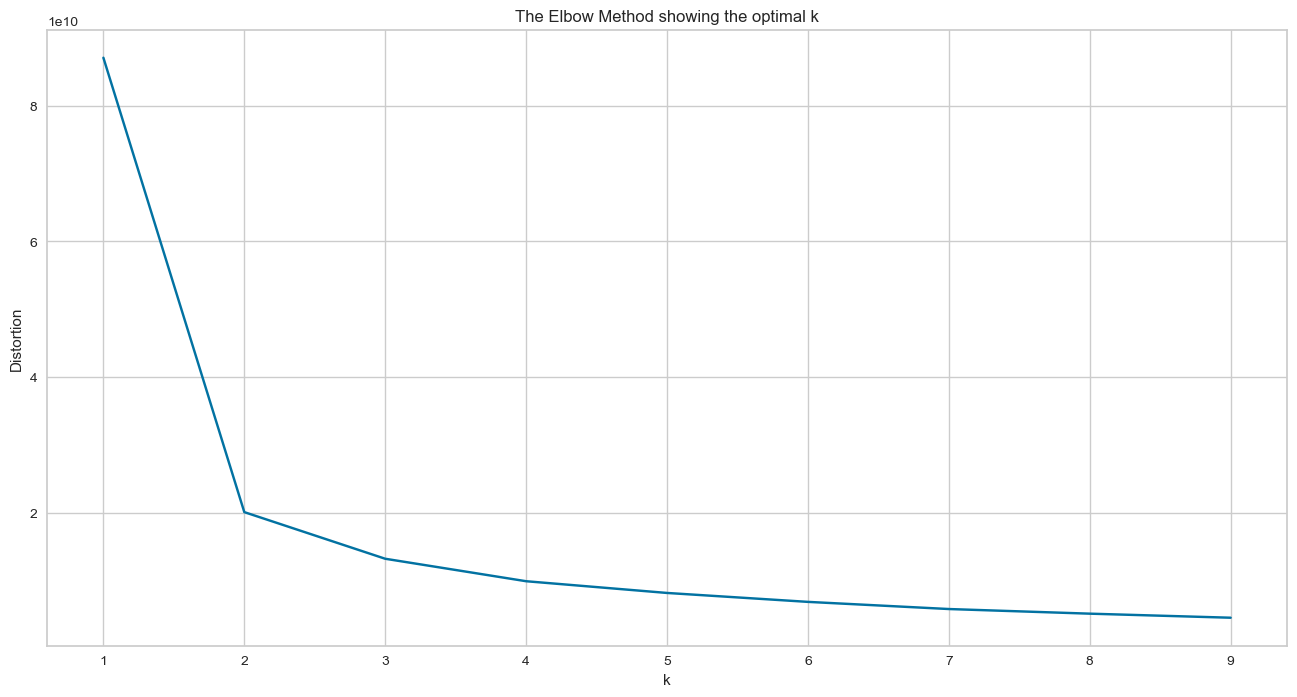

In [68]:
# Extracting the features
X = df_numeric 
X = X.values

# Using the elbow method to find the optimal number of clusters
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

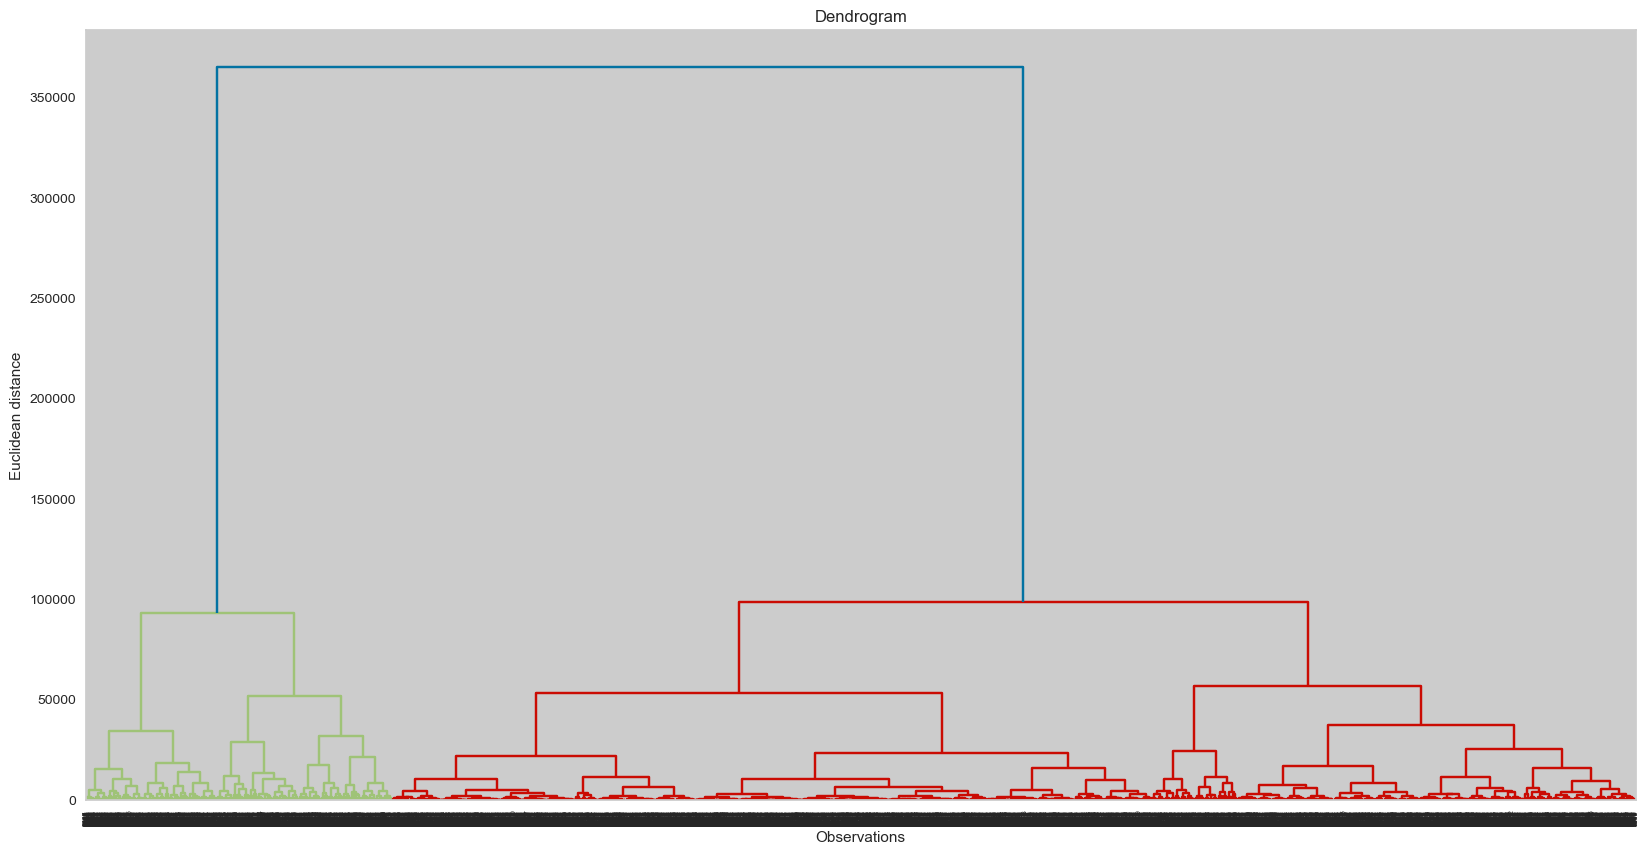

In [69]:
# Making the dendrogram to find the optimal number of clusters
plt.figure(figsize=(20,10))

dendogram = ch.dendrogram(ch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Euclidean distance')
plt.show()

In [70]:
# Hierarchical Clustering Model
n_clusters = 3
model = AgglomerativeClustering(n_clusters, affinity = 'euclidean', linkage = 'ward')
model.fit(X)

AgglomerativeClustering(affinity='euclidean', n_clusters=3)

In [71]:
X

array([[   2,    0,    1, ...,    2,   13, 2238],
       [   1,    0,    3, ...,    2,    9, 1892],
       [   2,    1,    0, ...,    2,    5, 2595],
       ...,
       [   2,    0,    3, ...,    8,    1, 2377],
       [   3,    1,    2, ...,    5,    8, 4574],
       [   1,    1,    1, ...,   11,    3,  826]], dtype=int64)

In [72]:
Y = model.fit_predict(X)
Y

array([2, 2, 1, ..., 2, 0, 0], dtype=int64)

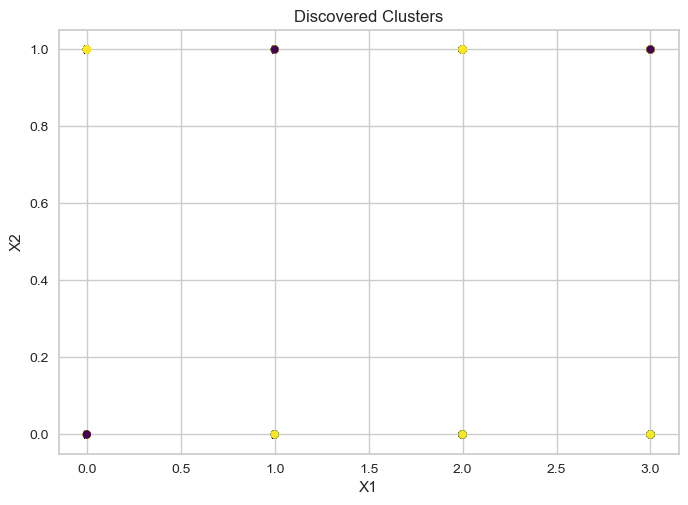

In [73]:
# Visualising the clusters
plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap='viridis')
plt.title('Discovered Clusters')
plt.xlabel('X1')
plt.ylabel('X2')
# plt.legend()
plt.show()

### K-means

In [74]:
# KMeans Clustering Model
# Extracting the features
X_kmeans = df_numeric 
X_kmeans = X_kmeans.values

X_kmeans

array([[   2,    0,    1, ...,    2,   13, 2238],
       [   1,    0,    3, ...,    2,    9, 1892],
       [   2,    1,    0, ...,    2,    5, 2595],
       ...,
       [   2,    0,    3, ...,    8,    1, 2377],
       [   3,    1,    2, ...,    5,    8, 4574],
       [   1,    1,    1, ...,   11,    3,  826]], dtype=int64)

In [75]:
# Using the elbow method to find the optimal number of clusters
distortions = []
K = range(2,10)
for k in K:
    model = KMeans(n_clusters=k, n_init=10).fit(X_kmeans)
    model.fit(X_kmeans)
    distortions.append(sum(np.min(cdist(X_kmeans, model.cluster_centers_, 'euclidean'), axis=1)) / X_kmeans.shape[0]) 
print("Distortion: ", distortions)

Distortion:  [1213.129741711301, 1021.5071234711668, 833.1622295595271, 726.9024688750078, 667.7589941752727, 634.4107002618714, 585.1943918712906, 561.1597884169943]


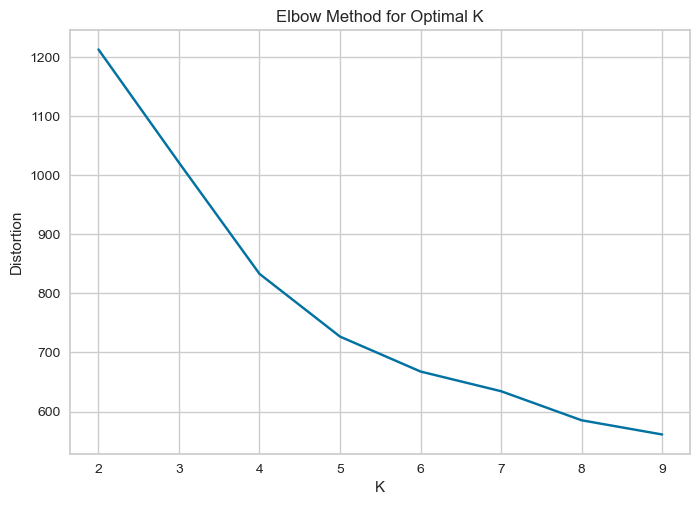

In [76]:
# Plotting the elbow method
plt.title('Elbow Method for Optimal K')
plt.plot(K, distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.show()

In [77]:
k_clusters = 4

In [78]:
kmeans = KMeans(init='k-means++', n_clusters=k_clusters, n_init=20)

In [79]:
kmeans.fit(X_kmeans)

KMeans(n_clusters=4, n_init=20)

In [80]:
# Silhouette score for KMeans clustering for different number of clusters
scores = []
K = range(2, 10)
for k in K:
    model = KMeans(n_clusters=k, n_init=10)
    model.fit(X_kmeans)
    score = metrics.silhouette_score(X_kmeans, model.labels_, metric='euclidean', sample_size=len(X_kmeans))
    print("\nNumber of clusters =", k)
    print("Silhouette score =", score)
    scores.append(score)


Number of clusters = 2
Silhouette score = 0.7276288250547488

Number of clusters = 3
Silhouette score = 0.6244532103619639

Number of clusters = 4
Silhouette score = 0.4438990022372207

Number of clusters = 5
Silhouette score = 0.41728194444699995

Number of clusters = 6
Silhouette score = 0.41750147213296634

Number of clusters = 7
Silhouette score = 0.41583313974597785

Number of clusters = 8
Silhouette score = 0.4151557760336107

Number of clusters = 9
Silhouette score = 0.41538315066099657


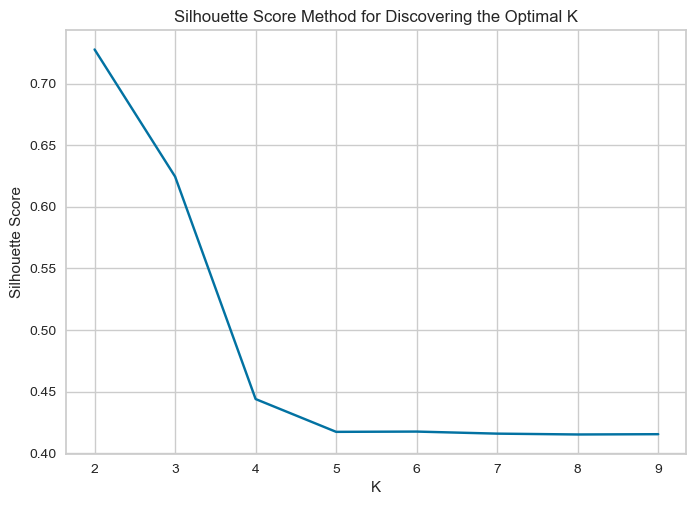

In [81]:
# Plot the elbow
plt.title('Silhouette Score Method for Discovering the Optimal K')
plt.plot(K, scores, 'bx-')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show()

In [82]:
y = kmeans.predict(X_kmeans)
y

array([2, 2, 0, ..., 2, 1, 1])

In [83]:
print(kmeans.labels_)

[2 2 0 ... 2 1 1]


Cluster  0 :  (2550, 20)


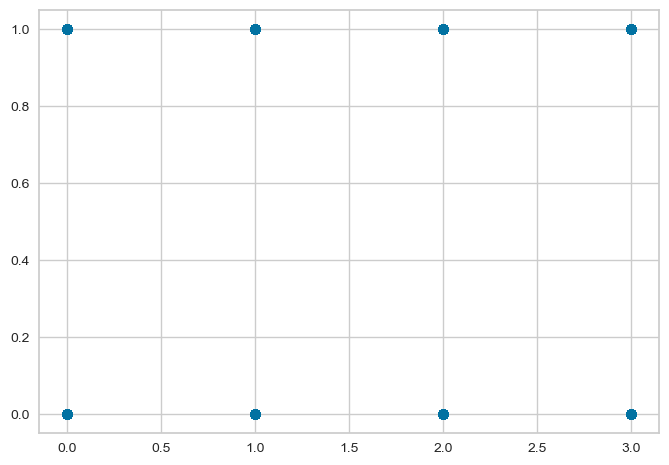

Cluster  1 :  (1116, 20)


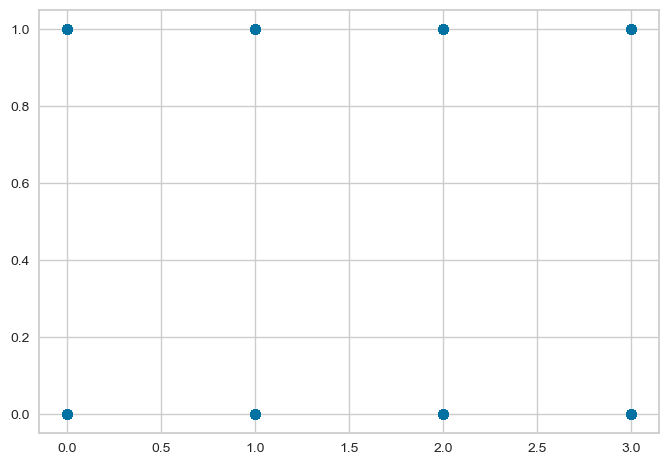

Cluster  2 :  (5250, 20)


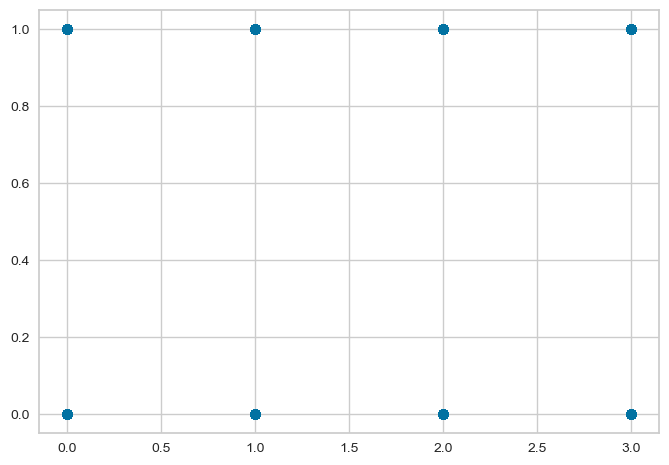

Cluster  3 :  (1084, 20)


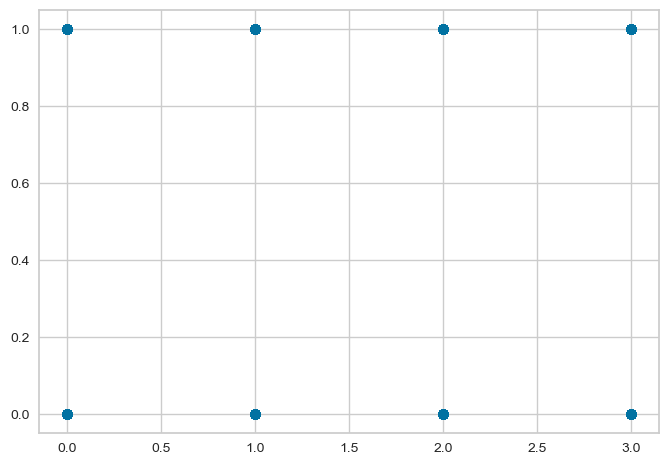

In [84]:
# Visualising the endividual clusters
for i in range(k_clusters):
    # slice the cluster
    cluster = X_kmeans[y == i]    
    # print the shape
    print("Cluster ", i, ": ", cluster.shape)    
    # plot the points of this cluster
    plt.scatter(cluster[:, 0], cluster[:, 1])   
    plt.grid(True)
    plt.show()

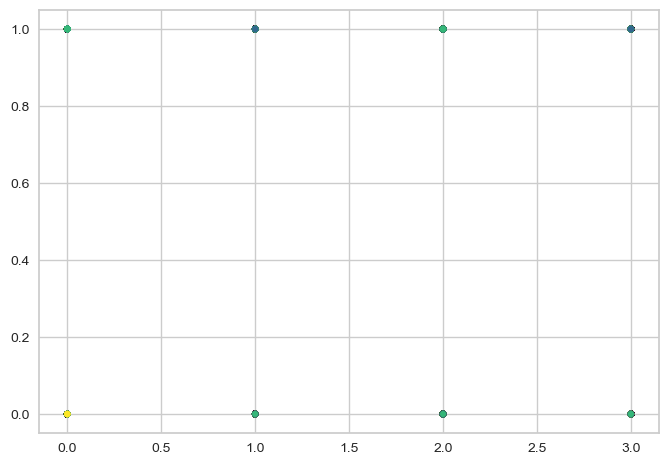

In [85]:
# Visualising all the clusters
plt.scatter(X_kmeans[:, 0], X_kmeans[:, 1], c=y, s=20, cmap='viridis')
plt.grid(True)
plt.show()

In [86]:
print(kmeans.cluster_centers_)

[[1.50196078e+00 5.13725490e-01 1.50470588e+00 1.48705882e+00
  1.48196078e+00 6.88627451e-01 9.36470588e-01 1.00000000e+00
  1.75826275e+02 1.50901961e+00 1.70796549e+03 1.50666667e+00
  4.04509804e+00 1.19905882e+01 2.53113725e+01 1.19972549e+01
  9.97647059e-01 7.47529412e+00 7.69803922e+00 2.13639373e+03]
 [1.50716846e+00 5.08064516e-01 1.43727599e+00 1.55465950e+00
  1.46863799e+00 4.21884749e-15 3.12634409e+00 9.76702509e-01
  1.79342294e+02 1.56630824e+00 8.40066129e+03 1.42383513e+00
  4.04480287e+00 1.23521505e+01 2.53396057e+01 1.17007168e+01
  1.00806452e+00 7.78942652e+00 7.42473118e+00 3.82900269e+03]
 [1.50685714e+00 4.97523810e-01 1.50628571e+00 1.47333333e+00
  1.49866667e+00 1.59847619e+00 1.65142857e-01 9.80380952e-01
  1.72186095e+02 1.48704762e+00 2.01140381e+02 1.51447619e+00
  4.01561905e+00 1.22400000e+01 2.48188571e+01 1.18295238e+01
  1.00552381e+00 7.53809524e+00 7.45504762e+00 1.88155867e+03]
 [1.54151292e+00 4.64944649e-01 1.44833948e+00 1.54520295e+00
  1.4

In [87]:
k = 5
model = KMeans(n_clusters=k, n_init=10)
model.fit_predict(X_kmeans)

array([4, 0, 2, ..., 4, 3, 3])

In [88]:
score = silhouette_score(X_kmeans, model.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.417


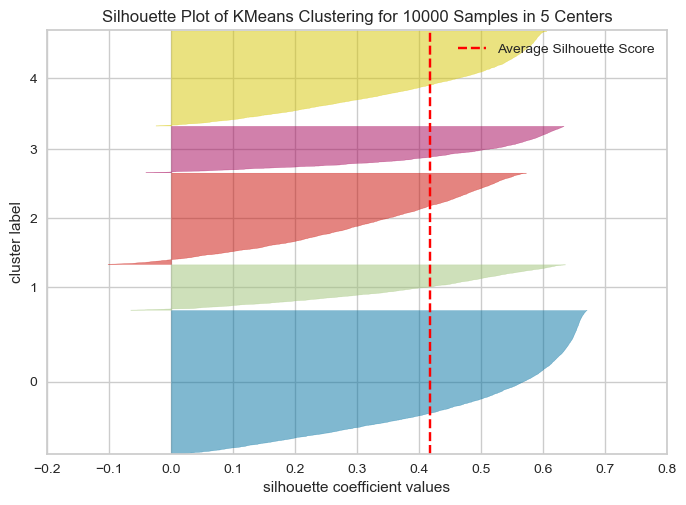

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [89]:
# Visualizing the Silhouette Score
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_kmeans)
visualizer.show()  

In [90]:
# Extracting the features
x_ms = df_numeric
x_ms = x_ms.values

In [91]:
# Estimate the bandwidth of the data
bandwidth = estimate_bandwidth(x_ms, quantile=0.2, n_samples=200)
bandwidth 

1521.6254214114701

In [92]:
# Making the instance of the MeanShift model
msmodel = MeanShift(bandwidth=bandwidth, bin_seeding=True)
msmodel.fit(x_ms)

MeanShift(bandwidth=1521.6254214114701, bin_seeding=True)

In [93]:
# Getting the labels
labels = msmodel.labels_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
n_clusters_

2

In [94]:
cluster_centers = msmodel.cluster_centers_
cluster_centers
# Predict the cluster for all the samples
Y = msmodel.predict(x_ms)
Y

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

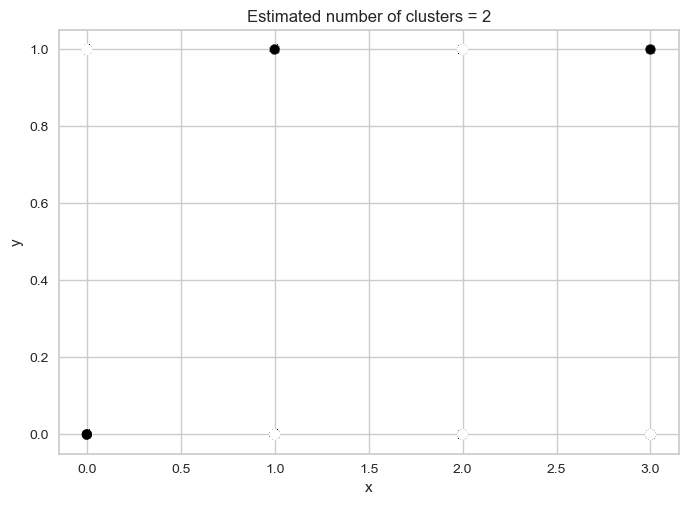

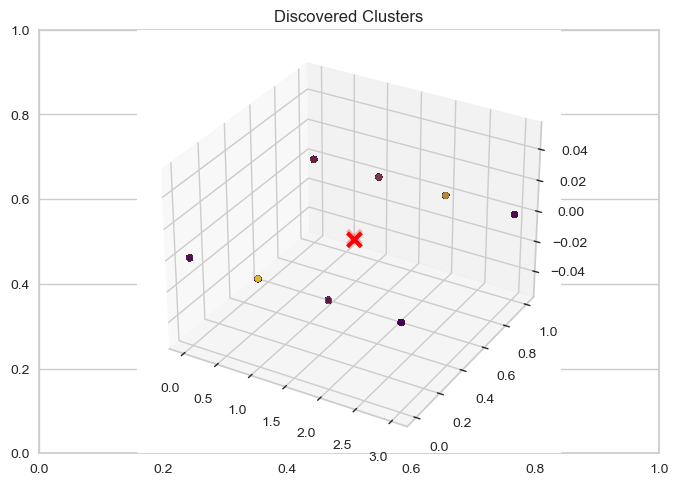

In [95]:
len(msmodel.labels_)

# Generate scatter plot for the training data
# s - marker size, here, the dots size
# c - marker color, here taken from the predicted clusters
plt.scatter(x_ms[:,0], x_ms[:,1], c=labels, marker="o", picker=True)
plt.title(f'Estimated number of clusters = {n_clusters_}')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Visualising the clusters in 3D
fig = plt.figure()
plt.title('Discovered Clusters')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_ms[:,0], x_ms[:,1],  marker='o', cmap='viridis', c=labels)
ax.scatter(cluster_centers[:,0], cluster_centers[:,1], marker='x', 
           color='red', s=100, linewidth=3, zorder=10)
plt.show()

#### Multible cluster model testing

K-means Silhouette Score: 0.7272517673342564
K-means Davies-Bouldin Index: 0.47170236271604965


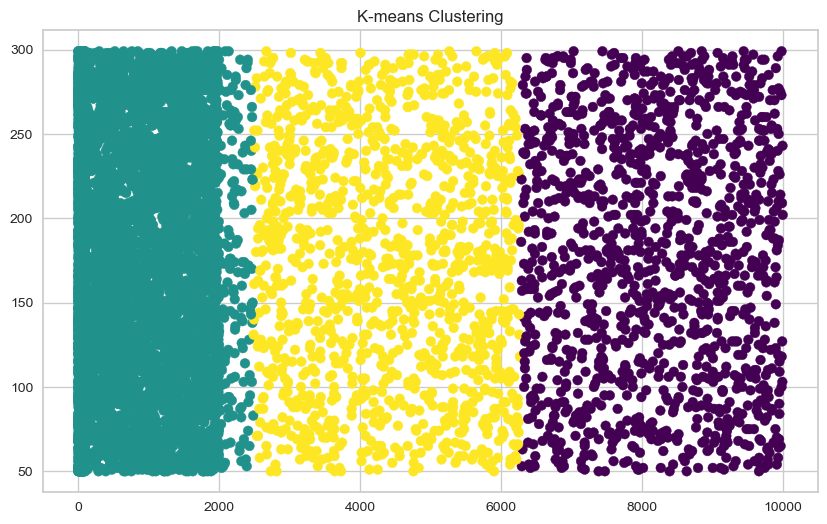


Hierarchical Silhouette Score: 0.6987582302409265
Hierarchical Davies-Bouldin Index: 0.48067426292775245


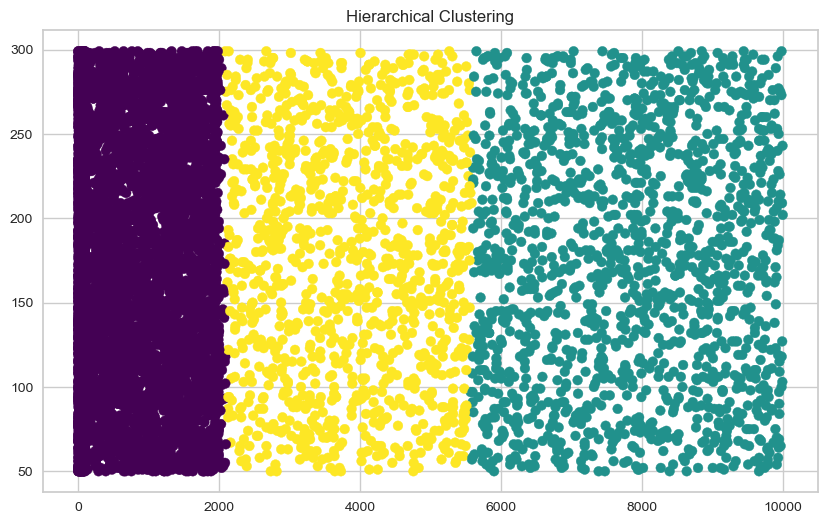


DBSCAN Silhouette Score:


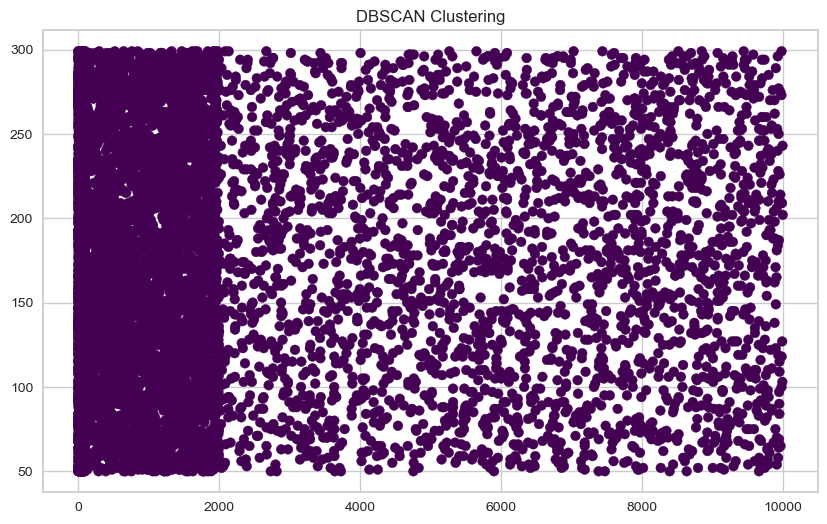


Mean Shift Silhouette Score: 0.5972466963485201
Mean Shift Davies-Bouldin Index: 0.5220474785135396


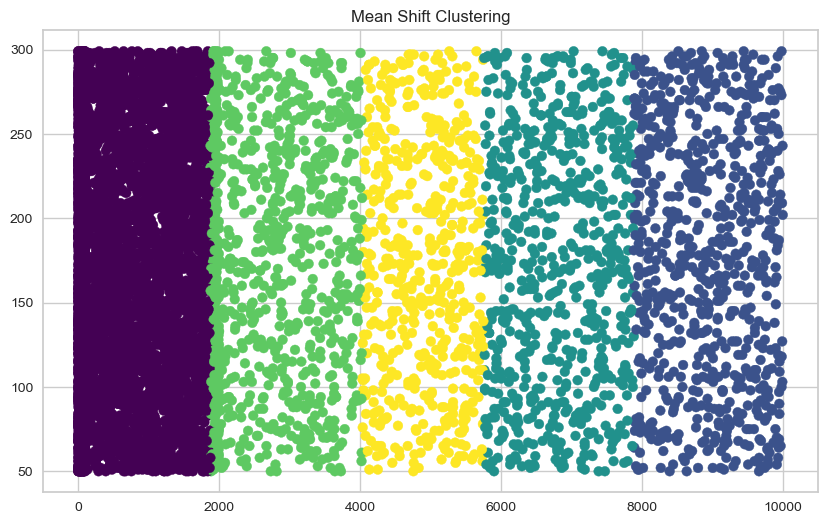

In [96]:
# Feature selection
data_scaled = df_numeric[['Vehicle Monthly Distance Km', 'Monthly Grocery Bill', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour', 'How Many New Clothes Monthly', 'How Long Internet Daily Hour']]
data_scaled = data_scaled.values

# Initialize the models for clustering (KMeans, Hierarchical, DBSCAN, Mean Shift) 
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_clusters = kmeans.fit_predict(data_scaled)

hierarchical = AgglomerativeClustering(n_clusters=3)
hierarchical_clusters = hierarchical.fit_predict(data_scaled)

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(data_scaled)

bandwidth = estimate_bandwidth(data_scaled, quantile=0.2, n_samples=500)
mean_shift = MeanShift(bandwidth=bandwidth)
mean_shift_clusters = mean_shift.fit_predict(data_scaled)


# Evaluate the models using Silhouette Score and Davies-Bouldin Index, and visualize the clusters
print("K-means Silhouette Score:", silhouette_score(data_scaled, kmeans_clusters))
print("K-means Davies-Bouldin Index:", davies_bouldin_score(data_scaled, kmeans_clusters))

plt.figure(figsize=(10, 6))
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=kmeans_clusters, cmap='viridis')
plt.title('K-means Clustering')
plt.show()

print()
print("Hierarchical Silhouette Score:", silhouette_score(data_scaled, hierarchical_clusters))
print("Hierarchical Davies-Bouldin Index:", davies_bouldin_score(data_scaled, hierarchical_clusters))

plt.figure(figsize=(10, 6))
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=hierarchical_clusters, cmap='viridis')
plt.title('Hierarchical Clustering')
plt.show()


print()

print("DBSCAN Silhouette Score:")

plt.figure(figsize=(10, 6))
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=dbscan_clusters, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.show()

print()

print("Mean Shift Silhouette Score:", silhouette_score(data_scaled, mean_shift_clusters))
print("Mean Shift Davies-Bouldin Index:", davies_bouldin_score(data_scaled, mean_shift_clusters))

plt.figure(figsize=(10, 6))
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=mean_shift_clusters, cmap='viridis')
plt.title('Mean Shift Clustering')
plt.show()


#### Clustering summary:

We have try using K-means, Hierarchical clustering, DBSCAN & Mean shift to see if there are any patterns in the data, but it seems that there are no clear patterns in the data, when applying these clustering methods to the hole dataset. We have tried with and without scaling the data. Additionally, we have tried to use different numbers of clusters, but the results are still the same. 
This is concluded based on the visualisation of the clusters from the different methods due to the visualistations being porly; However, the silhouette score have actually been quite high, which indicates that there are some patterns in the data.

Silhouette score:
* K-means: 0.727 (with 2 clusters), 0.624 (with 3 clusters)
* Hierarchical clustering: 0.426
* Mean shift: 0.727
* DBSCAN: indicates one clusters in the data

We have also tried using only some parts of the datas features, these results are gives som visualisation endication of patterns.
The features used for the clustering are: 'Monthly Grocery Bill', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour', 'How Many New Clothes Monthly', 'How Long Internet Daily Hour'

Silhouette score:
* K-means: 0.79 (with 2 clusters), 0.727 (with 3 clusters)
* Hierarchical clustering: 0.698
* Mean shift: 0.597
* DBSCAN: indicates one clusters in the data

Other features combinations have also been tried, but the results gives similar visualisation and silhouette score.

## Conclusion

Theres much interesing information in exploring this dataset, and we can definetely find a lot of patterns that is crucial for identifying which personal lifestyle factors are significant when it comes to calculationg our total carbon emission output.

**Here is our discoveries summarized:**

- The most significant factors for an individuals carbon emission seem to be their choice of transport. People that drive many kilometers monthly in personal vehicles are also the one who have a tendency to have the highest carbon emissions.

- Theres a small indication that internet usage has an impact on carbon emissions to correlating factors, but no direct pattern can be concluded, so we deem it as insignificant

- There seem to be very little difference in the correlating factors between males and females

- People who see themselves as 'Energy efficient' only seem the emit about 1,5% less carbon than people who say they're 'Not energy efficient', which we conclude makes it insignificant

- People who travel with airplanes very frequently seem to emit around 22% more carbon on average, than people who never fly

We tried to use different classification machine learning methods to try and predict carbon output based on correlating factors, and clustering methods for trying to discov hidden patterns in the data.

For classification we tried:

- Naive Bayes classifier
- Decision Tree classifier
- Random Forest classifier

We tried several iterations for optimizing the models by adjusting the category amount and the normalisation of the input data. In the end, the RFC model was the most succesful, with an accuracy of aaround 92% with 3 categories. However, we deem the result as unsaticfactory, since the input data still is a bit unsuited for this kind of machine learning, with 92% of the data fitting into a single category.

For clustering we tried: 
- K-means
- Hierarchical clustering
- DBSCAN 
- Mean shift. 

These clustering models revealed no significant patters in the data, with the DBSCAN resulting in an optimal cluster amount of 1. Higest silhouette score was 0.79 for K-means with 2 clusters; however the visulaization of the clusters from the different models were poor, didnt give any further insight to the data in the form of given patterns. Only way to get better visualizations, was to use specific features and not the hole dataset. This was without a doubt one of the challenges in the project development.